# A chat bot for a motorcycle store

A simple store bot that can deal with sellers and buyers

In [ ]:
import os
from typing import Dict, List, Tuple, Any, Annotated, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
import google.generativeai as genai
from langchain.schema import HumanMessage, SystemMessage
from langgraph.graph import Graph, StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.tools import Tool
from langchain.vectorstores import FAISS
import base64
import pandas as pd
import numpy as np
import PIL
from PIL import Image
import torch
import torch.nn.functional as F
from transformers import CLIPProcessor, CLIPModel
import glob
import seaborn as sns

from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_core.messages.tool import ToolMessage
from langchain_core.messages.ai import AIMessage

from IPython.display import Image as Display

import requests

from random import randint

# Set your Google API key
# os.environ["GOOGLE_API_KEY"] = "your_google_api_key_here"


## Build with multimodal embedding (CILP)
when we will want to search the stock data with both texts and images

### Download CILP from HuggingFace Transformers

In [2]:
# from PIL import Image
# import requests

# from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)


inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
# print("Output results for model %s" % outputs)
# print(outputs)
# print(outputs.image_embeds)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
print(logits_per_image)
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
print(probs)

tensor([[24.5701, 19.3049]], grad_fn=<TBackward0>)
tensor([[0.9949, 0.0051]], grad_fn=<SoftmaxBackward0>)


In [3]:

# outputs.image_embeds.shape
# outputs.image_embeds.norm(dim=-1, keepdim=True)
# # outputs.text_embeds.shape
# outputs.text_embeds.norm(dim=-1, keepdim=True)

# outputs.image_embeds * outputs.text_embeds[0].T
# F.cosine_similarity(outputs.image_embeds,outputs.text_embeds)
# # F.cosine_similarity(outputs.image_embeds,outputs.text_embeds).softmax(dim=1)

### Use CILP to embed the stock products from the stock folder

In [4]:

# Initialize the Gemini model
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
multimodal_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

# Initialize CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# # Initialize embeddings
# embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-exp-03-07")
# embeddings = model

# Function to get CLIP embeddings
def get_clip_embeddings(image_path, text):
    image = Image.open(image_path)
    # print(type(image))
    inputs = processor(text=[text], images=[image], return_tensors="pt", padding=True).to(device)
    # print(text)
    # print(inputs.keys())
    # print(inputs)
    
    with torch.no_grad():
        outputs = model(**inputs)
        
    
    # Normalize embeddings
    image_embeds = outputs.image_embeds / outputs.image_embeds.norm(dim=-1, keepdim=True)
    text_embeds = outputs.text_embeds / outputs.text_embeds.norm(dim=-1, keepdim=True)
    
    return image_embeds[0].cpu().numpy(), text_embeds[0].cpu().numpy()

# Function to process stock folder
def process_stock_folder(stock_folder):
    items = []
    for item_folder in os.listdir(stock_folder):
        item_path = os.path.join(stock_folder, item_folder)
        if os.path.isdir(item_path):
            item_description = item_folder
            image_files = glob.glob(os.path.join(item_path, "*.[jJ][pP][gG]")) + \
                          glob.glob(os.path.join(item_path, "*.[pP][nN][gG]"))
            
            if image_files:
                image_path = image_files[0]  # Use the first image file
                image_embed, text_embed = get_clip_embeddings(image_path, item_description)
                
                items.append({
                    "description": item_description,
                    "image_path": image_path,
                    "image_embedding": image_embed,
                    "text_embedding": text_embed,
                    "quantity": randint(1, 10)
                })
    
    return pd.DataFrame(items)

# Process the stock folder and create DataFrame
current_dir = os.getcwd()
stock_folder = os.path.join(current_dir, "stock")  # Relative path from current working directory
stock_df = process_stock_folder(stock_folder)

# Display the first few rows of the DataFrame
print(stock_df.head())

# Initialize vector store for product inventory using the text embeddings
# vector_store = FAISS.from_texts(stock_df['description'].tolist(), embeddings)

# Print the contents of the stock folder
print("Contents of the stock folder:")
print(os.listdir(stock_folder))



              description                                         image_path  \
0  blue motorcycle helmet  c:\Users\User\Desktop\python-20221118T114714Z-...   
1  blue motorcycle jacket  c:\Users\User\Desktop\python-20221118T114714Z-...   
2  pink motorcycle helmet  c:\Users\User\Desktop\python-20221118T114714Z-...   
3  pink motorcycle jacket  c:\Users\User\Desktop\python-20221118T114714Z-...   

                                     image_embedding  \
0  [-0.016169827, 0.033344224, 0.004520249, -0.01...   
1  [0.015960498, 0.049181655, -0.0042695473, -0.0...   
2  [-0.02270329, -0.016800905, -0.007776018, -0.0...   
3  [-0.012356388, 0.016907725, 0.03439205, -0.011...   

                                      text_embedding  quantity  
0  [0.006697172, -0.030268285, 0.008442102, -0.02...         8  
1  [0.026581874, 0.013501018, 0.0068766265, 0.000...         4  
2  [-0.025257437, -0.026914252, 0.01546045, -0.08...         4  
3  [-0.0034928436, 0.013905618, 0.0055865482, -0....      

In [5]:
# stock_df["text_embedding"][0].shape
stock_df


,description,image_path,image_embedding,text_embedding,quantity
0,blue motorcycle helmet,c:\Users\User\Desktop\python-20221118T114714Z-...,"[-0.016169827, 0.033344224, 0.004520249, -0.01...","[0.006697172, -0.030268285, 0.008442102, -0.02...",8
1,blue motorcycle jacket,c:\Users\User\Desktop\python-20221118T114714Z-...,"[0.015960498, 0.049181655, -0.0042695473, -0.0...","[0.026581874, 0.013501018, 0.0068766265, 0.000...",4
2,pink motorcycle helmet,c:\Users\User\Desktop\python-20221118T114714Z-...,"[-0.02270329, -0.016800905, -0.007776018, -0.0...","[-0.025257437, -0.026914252, 0.01546045, -0.08...",4
3,pink motorcycle jacket,c:\Users\User\Desktop\python-20221118T114714Z-...,"[-0.012356388, 0.016907725, 0.03439205, -0.011...","[-0.0034928436, 0.013905618, 0.0055865482, -0....",4


### Test to see the similarity between the text vectors to the images vectors 

Similarity of text 0 with image 0: 0.3046668469905853
Similarity of text 0 with image 1: 0.27183520793914795
Similarity of text 0 with image 2: 0.2849934995174408
Similarity of text 0 with image 3: 0.17890003323554993
Similarity of text 1 with image 0: 0.2720431387424469
Similarity of text 1 with image 1: 0.34153616428375244
Similarity of text 1 with image 2: 0.21446247398853302
Similarity of text 1 with image 3: 0.27261221408843994
Similarity of text 2 with image 0: 0.23935312032699585
Similarity of text 2 with image 1: 0.2079290747642517
Similarity of text 2 with image 2: 0.356059193611145
Similarity of text 2 with image 3: 0.25056466460227966
Similarity of text 3 with image 0: 0.2027685046195984
Similarity of text 3 with image 1: 0.26573091745376587
Similarity of text 3 with image 2: 0.29121702909469604
Similarity of text 3 with image 3: 0.34333592653274536


<Axes: >

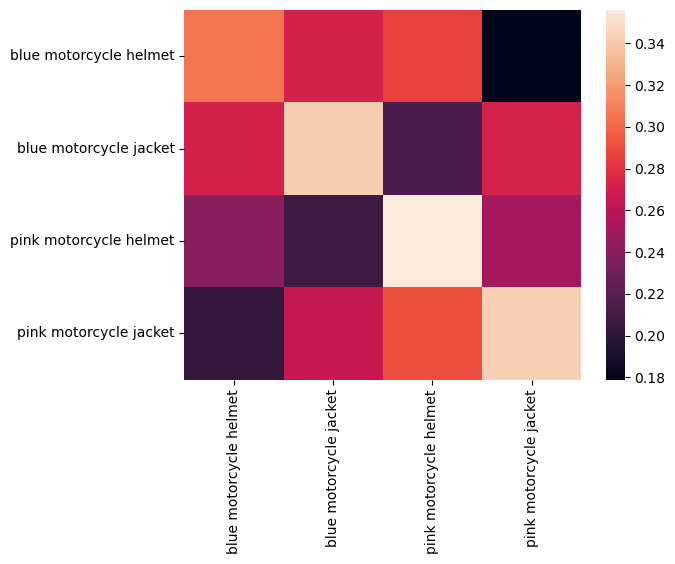

In [6]:

df = pd.DataFrame(index=stock_df['description'].to_list(), columns=stock_df['description'].to_list(),dtype=float)

(stock_df["text_embedding"] @ stock_df["image_embedding"].T).shape
stock_df["text_embedding"][0] @ stock_df["image_embedding"][0]
for i in stock_df.index:
    for j in stock_df.index:
        sim = (stock_df['text_embedding'][i] @ stock_df['image_embedding'][j]).item()
        print(f"Similarity of text {i} with image {j}: {sim}")
        df.iloc[i, j] = float(sim)

df
# sns.heatmap(df, vmin=0, vmax=1)
sns.heatmap(df)


Even when we see that the best similarity scores are between the correct text and image, the scores are pretty low.

Because of the low true similarity scores we will continue with only text embeddings

## Build with only text embeddings
use provided text embedder

### Use the best text-embedding from google to embed the stock products from the stock folder

In [ ]:


# # Initialize embeddings
# embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-exp-03-07",task_type='semantic_similarity')
document_embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-exp-03-07",task_type='retrieval_document')
query_embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-exp-03-07",task_type='retrieval_query')
# embeddings = model
# genai.embed_content(model='models/gemini-embedding-exp-03-07',
#                                content=texts,
#                                task_type='semantic_similarity')


# Function to process stock folder
def process_stock_folder(stock_folder):
    items = []
    for item_folder in os.listdir(stock_folder):
        item_path = os.path.join(stock_folder, item_folder)
        if os.path.isdir(item_path):
            item_description = item_folder
            image_files = glob.glob(os.path.join(item_path, "*.[jJ][pP][gG]")) + \
                          glob.glob(os.path.join(item_path, "*.[pP][nN][gG]"))
            
            if image_files:
                image_path = image_files[0]  # Use the first image file
                # get the embeddedings for the texts
                # print(item_description)
                text_embed = document_embeddings.embed_documents([item_description])
                
                items.append({
                    "description": item_description,
                    "image_path": image_path,
                    # "image_embedding": image_embed,
                    "text_embedding": text_embed,
                    "quantity": randint(1, 10)
                })
    
    return pd.DataFrame(items)

# Process the stock folder and create DataFrame
current_dir = os.getcwd()
stock_folder = os.path.join(current_dir, "stock")  # Relative path from current working directory
stock_df = process_stock_folder(stock_folder)

# Display the first few rows of the DataFrame
print(stock_df.head())

# Initialize vector store for product inventory using the text embeddings
# vector_store = FAISS.from_texts(stock_df['description'].tolist(), embeddings)
# vector_store = FAISS.from_embeddings(text_embeddings=stock_df["text_embedding"],,metadatas=stock_df.loc[:,["description","image_path"]])

# Print the contents of the stock folder
print("Contents of the stock folder:")
print(os.listdir(stock_folder))


              description                                         image_path  \
0  blue motorcycle helmet  c:\Users\User\Desktop\python-20221118T114714Z-...   
1  blue motorcycle jacket  c:\Users\User\Desktop\python-20221118T114714Z-...   
2  pink motorcycle helmet  c:\Users\User\Desktop\python-20221118T114714Z-...   
3  pink motorcycle jacket  c:\Users\User\Desktop\python-20221118T114714Z-...   

                                      text_embedding  quantity  
0  [[-0.025300219655036926, 0.01915992982685566, ...         8  
1  [[-0.015566835179924965, 0.0016746768960729241...         3  
2  [[-0.025420421734452248, 0.031576499342918396,...         2  
3  [[-0.014631759375333786, 0.01679047755897045, ...         8  
Contents of the stock folder:
['blue motorcycle helmet', 'blue motorcycle jacket', 'pink motorcycle helmet', 'pink motorcycle jacket']


#### Do a test search for a product

In [8]:


def search_product(query: str) -> pd.DataFrame:
    """Get item request description from the buyer and return the two most fitting products from the stock database.
    
    Returns:
        a pandas DataFrame of the two most fitting products.
    """
    test_query_embedding = query_embeddings.embed_query(query)
    scores = stock_df.loc[stock_df["quantity"]>0,"text_embedding"].apply(lambda x: np.array(test_query_embedding) @ np.array(x[0]))
    return stock_df.loc[scores.sort_values(ascending=False).index[:2],["description","image_path","quantity"]]

# test_query_text = "i want a pink helmet"
test_query_text = "find me a jacket"
# test_query_embedding = query_embeddings.embed_query(test_query_text)
search_product(test_query_text)


,description,image_path,quantity
1,blue motorcycle jacket,c:\Users\User\Desktop\python-20221118T114714Z-...,3
3,pink motorcycle jacket,c:\Users\User\Desktop\python-20221118T114714Z-...,8


In [9]:

# len(test_query_embedding)
# stock_df["text_embedding"]
# # stock_df["text_embedding"] @ test_query_embedding
# # test_query_embedding @ stock_df["text_embedding"][0]
# np.array(test_query_embedding)
# stock_df["text_embedding"].to_numpy()

# # similarity_matrix = stock_df["text_embedding"].to_numpy() @ test_query_embedding
# scores = stock_df["text_embedding"].apply(lambda x: np.array(test_query_embedding) @ np.array(x[0]))
# scores.sort_values(ascending=False)
# stock_df.loc[scores.sort_values(ascending=False).index[:2],["description","image_path"]]
# # np.array(test_query_embedding) @ np.array(stock_df["text_embedding"][3][0])

# # stock_df["text_embedding"][0][0]
# # np.array(stock_df["text_embedding"][0]).shape
# # len(stock_df["text_embedding"][0])

# Build a test bot

In [10]:
# order: pd.DataFrame = pd.DataFrame(index=None, columns=["description","image_path","quantity"])
# type(order)
# # state:State = None
# # order = state.get("order", [])
# order


## Initialize the bot

In [11]:

# Initialize the Gemini model
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
# multimodal_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")


class State(TypedDict):
    """State representing the customer's order conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # The customer's in-progress order.
    # order: list[str]
    # order: list[pd.Series]
    order: pd.DataFrame # = pd.DataFrame(index=None, columns=["description","image_path","quantity"])
    user_type: Literal["seller", "buyer", "unknown"] = "unknown"

    # The current stock database
    stock_database: pd.DataFrame = stock_df

    # Flag indicating that the order is placed and completed.
    finished: bool

# # Define the state
# class State(BaseModel):
#     """State representing the customer's order conversation or seller item input."""
#     messages: List[str] = Field(default_factory=list)
#     current_operation: str = "idle"
#     stock_database: pd.DataFrame = Field(default_factory=pd.DataFrame)


# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
MOTORCYCLESTOREBOT_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are a MotorcycleStoreBot, an interactive motorcycle store managing system. "
    "there are two types of humans that can talk to you: "
    "\n\ta seller: sellers can look at the stock database and ask to add or remove items from the database."
    "\t\t if they want to add an item they need to give its description in text and give an image of the item."
    "\t\t if they want to remove an item from the database they need to give its description or its index in the database"
    "\n\tcustomer: customers can ask questions about the stock database and ask for help."
    "\t\t if they want to find an item they need to give a description and you will look in the stock database "
    "for the closest available items, if you find an item that is close to what they want you will offer it to them, "
    "if the closest available items are not similar to what they want you will say that we don't have any items close to what they want"
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to Lior's Motorcycle Store. Type `q` to quit. How may I help you today?"




## Define the tools that the bot can use

In [12]:


# add needed tools for the bot
@tool
def search_product(query: str) -> str:
    """Get item request description from the buyer and return the two most fitting products from the stock database.
    
    Returns:
        a list of the two most fitting products that are still in stock.
        also prints the descriptions and product pictures to the buyer
    """

# @tool
# def add_product(product_description: str, product_image:PIL.JpegImagePlugin.JpegImageFile) -> None:
#     """Add a new product to the stock database.
    
#     Args:
#         product_description (str): Description of the product.
#         product_image (PIL.JpegImagePlugin.JpegImageFile): Image of the product.

#     Returns:
#         None
#     """
@tool
def add_product(product_description: str, product_image_path:str, product_quantity:int) -> str:
    """Add a new product to the stock database.
    Also displays the new addition back to the seller.
    
    Args:
        product_description (str): Description of the product.
        product_image (str): The path to rhe Image of the product.
        product_quantity (int): The quantity of the product.

    Returns:
        Confirmation message indicating success or failure.
    """
  
# @tool
# def add_to_order(item: str, item_count: int) -> str:
#     """Adds the wanted item to the buyer's order, including amount of wanted items.

#     Returns:
#       The updated order in progress.
#     """
@tool
def add_to_order(product_number: int, item_count: int) -> str:
    """Takes the product number of the wanted item and the wanted quantity, and adds it to the order.

    Returns:
      The updated order in progress.
    """

@tool
def get_order() -> str:
    """Returns the users order so far. One item per line."""
  
@tool
def clear_order():
    """Removes all items from the user's order."""
    
@tool
def confirm_order() -> str:
    """Asks the customer if the order is correct.

    Returns:
      The user's free-text response.
    """


@tool
def place_order() -> bool:
    """Sends the order to the stock for fulfillment.

    Returns:
      Confirmation message indicating success or failure.
    """


## Define the bot functionality

In [ ]:


tools = [search_product, add_product, add_to_order, get_order, clear_order, confirm_order, place_order]

# The LLM needs to know about all of the tools, so specify everything here.
llm_with_tools = llm.bind_tools(tools)


def human_node(state: State) -> State:
    """Display the last model message to the user, and receive the user's input."""
    # print("in human_node")
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")
    print("User:", user_input)

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}

def maybe_exit_human_node(state: State) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    # print("in maybe_exit_human_node")
    if state.get("finished", False):
        return END
    else:
        return "chatbot"
    
def chatbot_with_tools(state: State) -> State:
    # print("started chatbot")
    # print("in chatbot")
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"order": [], "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([MOTORCYCLESTOREBOT_SYSINT] + state["messages"])
        # try:
        #     if len(new_output["content"]) <= 0:
        #         new_output["content"] = "working on the task..."
        #         # print(new_output)
        # except Exception as e:
        #     print(f"Error in invoking LLM: {e}")
        #     print(f"type of new_output: {type(new_output)}")
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    # print(f"type of new_output: {type(new_output)}")
    print(new_output)
    return defaults | state | {"messages": [new_output]}


def seller_or_buyer(state: State) -> Literal["seller", "buyer"]:
    """Decide whether the user is a seller or a buyer based on their message"""
    # print("in seller_or_buyer")
    # if state["user_type"] is not "unknown":
    if state["user_type"] != "unknown":
        return state["user_type"]
    else:
        # If the user's type is not known, let's ask the user.
        state["user_type"] = "seller" if input("Are you a seller or a buyer? (seller/buyer): ").lower() == "seller" else "buyer"
        return state["user_type"]
def seller_or_buyer2(state: State) -> Literal["seller", "buyer","__end__","human"]:
    """Decide whether the user is a seller or a buyer based on their message"""
    # print("in seller_or_buyer2")
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    msg = msgs[-1]
    # print(msg)

    if state.get("finished", False):
        # When an order is placed, exit the app. The system instruction indicates
        # that the chatbot should say thanks and goodbye at this point, so we can exit
        # cleanly.
        print("Model:", msg.content)
        # print("to END")
        return END

    elif hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        # to seller if it want to use add_product
        if any(
            tool["name"] in ["add_product",] for tool in msg.tool_calls
        ):
            # print("to seller node")
            return "seller"
        elif any(
            tool["name"] in ["search_product", "add_to_order", "get_order", "clear_order", "confirm_order", "place_order"] for tool in msg.tool_calls
        ):
            # print("to buyer node")
            return "buyer"
    else:
        # print("to human node")
        return "human"

    
def seller_node(state: State) -> State:
    """The seller node. This is where the seller can add new items to the stock database"""
    # print("in seller_node")
    tool_msg = state.get("messages", [])[-1]
    order = state.get("order", pd.DataFrame(index=None, columns=["description","image_path","quantity"]))
    # print(f"order type is {type(order)}")
    outbound_msgs = []
    order_placed = False
    
    for tool_call in tool_msg.tool_calls:

        if tool_call["name"] == "add_product":
            print("Adding product")
            idx = stock_df.index.max() + 1
            stock_df.loc[idx,"description"] = tool_call["args"]["product_description"]
            stock_df.loc[idx,"image_path"] = tool_call["args"]["product_image_path"]
            stock_df.loc[idx,"quantity"] = tool_call["args"]["product_quantity"]
            stock_df.at[idx,"text_embedding"] = document_embeddings.embed_documents([tool_call["args"]["product_description"]])
            # stock_df.loc[idx,"text_embedding"] = [document_embeddings.embed_documents([tool_call["args"]["product_description"]])]
            # stock_df.loc[idx,"text_embedding"] = stock_df.loc[idx,"text_embedding"][0]
            response = "Product added successfully!"
            print(response)
            print(stock_df.loc[idx,["description","image_path","quantity"]])
            image_path = stock_df.loc[idx,"image_path"]
            # Open the image file
            img = Image.open(image_path)
            # Resize the image (optional)
            # img_resized = img.resize((300, 300))  # Adjust the size as needed
            img_resized = img.resize((img._size[0]//4, img._size[1]//4))  # Adjust the size as needed
            # Display the image
            # display(img)
            display(img_resized)
        
        else:
            raise NotImplementedError(f'Unknown tool call: {tool_call["name"]}')
        
        # Record the tool results as tool messages.
        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {"messages": outbound_msgs, "order": order, "finished": order_placed}
def buyer_node(state: State) -> State:
    """The seller node. This is where the seller can add new items to the stock database"""
    # print("in buyer_node")
    tool_msg = state.get("messages", [])[-1]
    order = state.get("order", pd.DataFrame(index=None, columns=["description","image_path","quantity"]))
    # print(f"order type is {type(order)}")
    outbound_msgs = []
    order_placed = False
    
    for tool_call in tool_msg.tool_calls:

    # scores = stock_df.loc[stock_df["quantity"]>0,"text_embedding"].apply(lambda x: np.array(test_query_embedding) @ np.array(x[0]))
    # return stock_df.loc[scores.sort_values(ascending=False).index[:2],["description","image_path","quantity"]]
        if tool_call["name"] == "search_product":
            print("Searching for products...")
            n = 2 # number of products to search for
            test_query_embedding = query_embeddings.embed_query(tool_call["args"]["query"])
            scores = stock_df.loc[stock_df["quantity"]>0,"text_embedding"].apply(lambda x: np.array(test_query_embedding) @ np.array(x[0]))
            best_fits = stock_df.loc[scores.sort_values(ascending=False).index[:n],["description","image_path","quantity"]]
            # response = best_fits.to_string()
            response:str = ""
            for product_inx in best_fits.index:
                response += f"product_number: {product_inx}\ndescription: {stock_df.loc[product_inx,'description']}\nquantity: {stock_df.loc[product_inx,'quantity']}\npicture:\n{stock_df.loc[product_inx,'image_path']}\n\n"
                print(f"product number: {product_inx}")
                print(f"description: {stock_df.loc[product_inx,'description']}")
                print(f"quantity remaining: {stock_df.loc[product_inx,'quantity']}")
                print("picture:")
                image_path = best_fits.loc[product_inx,"image_path"]
                # Open the image file
                img = Image.open(image_path)
                # Resize the image (optional)
                # img_resized = img.resize((300, 300))  # Adjust the size as needed
                img_resized = img.resize((img._size[0]//4, img._size[1]//4))  # Adjust the size as needed
                # Display the image
                # display(img)
                display(img_resized)
        
        elif tool_call["name"] == "add_to_order":
            # print(f"current order length: {len(order)}")
            print("Adding to order...")
            # print(tool_call["args"])
            # print(f"order type is {type(order)}")
            # order.append(f'{tool_call["args"]["item"]} ({tool_call["args"]["item_count"]})')
            # response = "\n".join(order)
            if type(order) != pd.DataFrame:
                # print("reseting order type")
                order = pd.DataFrame(index=None, columns=["description","image_path","quantity"])
            wanted_product_number = int(tool_call["args"]["product_number"])
            if tool_call["args"]["item_count"] > stock_df.loc[wanted_product_number,"quantity"]:
                response = "Not enough stock for this item."
            # elif len(order.index) > 0:
            elif wanted_product_number in order.index:
                print("adding more quantity to ordered product")
                order.loc[wanted_product_number, "quantity"] += tool_call["args"]["item_count"]
                stock_df.loc[wanted_product_number,"quantity"] -= tool_call["args"]["item_count"]
                # response = f"Added {tool_call['args']['item_count']} of product {tool_call['args']['product_number']} to the order."
                response = order.to_string()
            else:
                print("adding a new product to order")
                new_order = pd.DataFrame(index=[wanted_product_number], columns=["description","image_path","quantity"])
                new_order.loc[wanted_product_number,["description","image_path"]] = stock_df.loc[wanted_product_number,["description","image_path"]].copy()
                new_order.loc[wanted_product_number, "quantity"] = tool_call["args"]["item_count"]
                stock_df.loc[wanted_product_number,"quantity"] -= tool_call["args"]["item_count"]
                # response = f"Added {tool_call['args']['item_count']} of product {tool_call['args']['product_number']} to the order."
                print("new_order")
                print(new_order)
                print("old order")
                print(order)
                print("merged order")
                print(pd.concat([order, new_order], ignore_index=False))
                order = pd.concat([order, new_order], ignore_index=False)
                # order.append(new_order)
                response = order.to_string()
            print(f"new current order length: {len(order)}")


        elif tool_call["name"] == "confirm_order":
            print("Confirming order...")
            # We could entrust the LLM to do order confirmation, but it is a good practice to
            # show the user the exact data that comprises their order so that what they confirm
            # precisely matches the order that goes to the kitchen - avoiding hallucination
            # or reality skew.

            # In a real scenario, this is where you would connect your POS screen to show the
            # order to the user.

            print("Your order:")
            # if not order:
            if len(order) == 0:
                print("  (no items)")

            for item in order:
                print(f"  {item}")

            response = input("Is this correct? ")

        elif tool_call["name"] == "get_order":
            print("Getting order...")
            print(f"length of order is: {len(order)}")
            # response = "\n".join(order) if order else "(no order)"
            response = order.to_string()
            print(response)

        elif tool_call["name"] == "clear_order":
            print("Clearing order...")
            # order.clear()
            order = pd.DataFrame(index=None, columns=["description","image_path","quantity"])
            response = None

        elif tool_call["name"] == "place_order":
            print("Placing order...")
            print(f"length of order is: {len(order)}")
            # order_text = "\n".join(order)
            order_text = order.to_string()
            print("Sending order store")
            print(order_text)
            # print(order)

            order_placed = True
            response = True 

        else:
            raise NotImplementedError(f'Unknown tool call: {tool_call["name"]}')
        
        # Record the tool results as tool messages.
        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    print(f"messages: {outbound_msgs}")
    print(f"order: {order}")
    print(f"finished: {order_placed}")
    if len(outbound_msgs) > 1:
        print("WARNING: Multiple messages were generated, this is not a typical scenario!")
        outbound_msgs = str(outbound_msgs)
    return {"messages": outbound_msgs, "order": order, "finished": order_placed}







    # if state["user_type"] == "seller":
    #     product_description = input("Enter the description of the product: ")
    #     product_image = PIL.Image.open(input("Enter the path to the image of the product: "))




## Build the graph for the bot

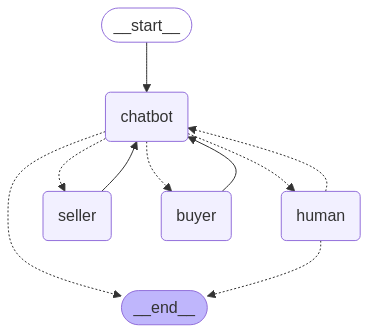

In [14]:


graph_builder = StateGraph(State)

# Nodes
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("seller", seller_node)
graph_builder.add_node("buyer", buyer_node)

# Chatbot -> {ordering, tools, human, END}
graph_builder.add_conditional_edges("chatbot", seller_or_buyer2)
# Human -> {chatbot, END}
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools (both kinds) always route back to chat afterwards.
graph_builder.add_edge("seller", "chatbot")
graph_builder.add_edge("buyer", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_order_tools = graph_builder.compile()

Display(graph_with_order_tools.get_graph().draw_mermaid_png())



## Chat with the bot

content="Welcome to Lior's Motorcycle Store. Type `q` to quit. How may I help you today?" additional_kwargs={} response_metadata={}
Model: Welcome to Lior's Motorcycle Store. Type `q` to quit. How may I help you today?
User: i want a bike
content='' additional_kwargs={'function_call': {'name': 'search_product', 'arguments': '{"query": "bike"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-e3ac19cd-a037-4d4f-9856-8a993a4875c7-0' tool_calls=[{'name': 'search_product', 'args': {'query': 'bike'}, 'id': '79f3c6c6-2ac4-4834-8517-fd16631fcb3d', 'type': 'tool_call'}] usage_metadata={'input_tokens': 510, 'output_tokens': 5, 'total_tokens': 515, 'input_token_details': {'cache_read': 0}}
Searching for products...
product number: 2
description: pink motorcycle helmet
quantity remaining: 2
picture:


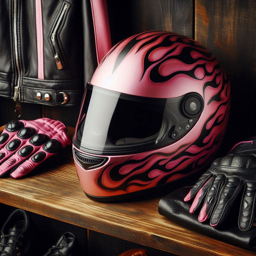

product number: 3
description: pink motorcycle jacket
quantity remaining: 8
picture:


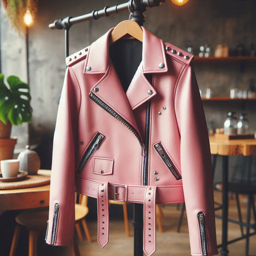

messages: [ToolMessage(content='product_number: 2\ndescription: pink motorcycle helmet\nquantity: 2\npicture:\nc:\\Users\\User\\Desktop\\python-20221118T114714Z-001\\python\\motorcycle-store-bot\\stock\\pink motorcycle helmet\\_c14b5fcc-08f0-4e22-961a-f50a923e17f9.jpg\n\nproduct_number: 3\ndescription: pink motorcycle jacket\nquantity: 8\npicture:\nc:\\Users\\User\\Desktop\\python-20221118T114714Z-001\\python\\motorcycle-store-bot\\stock\\pink motorcycle jacket\\_00f10fe3-43b9-474b-971c-d5b9101b97a7.jpg\n\n', name='search_product', tool_call_id='79f3c6c6-2ac4-4834-8517-fd16631fcb3d')]
order: []
finished: False
content='We have a pink motorcycle helmet and a pink motorcycle jacket. Are you interested in any of these?' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-d1e453e0-cd8c-461c-b56e-ae35d4d80dfc-0' usage_metadata={'input_tokens': 726, 'output_tokens': 21, 'total_tokens': 74

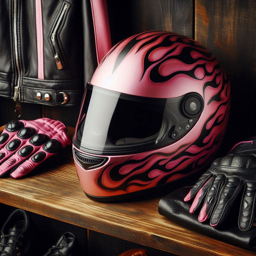

product number: 3
description: pink motorcycle jacket
quantity remaining: 8
picture:


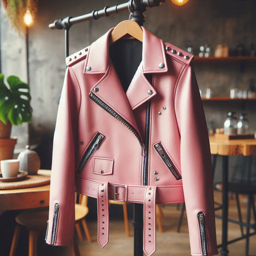

messages: [ToolMessage(content='product_number: 2\ndescription: pink motorcycle helmet\nquantity: 2\npicture:\nc:\\Users\\User\\Desktop\\python-20221118T114714Z-001\\python\\motorcycle-store-bot\\stock\\pink motorcycle helmet\\_c14b5fcc-08f0-4e22-961a-f50a923e17f9.jpg\n\nproduct_number: 3\ndescription: pink motorcycle jacket\nquantity: 8\npicture:\nc:\\Users\\User\\Desktop\\python-20221118T114714Z-001\\python\\motorcycle-store-bot\\stock\\pink motorcycle jacket\\_00f10fe3-43b9-474b-971c-d5b9101b97a7.jpg\n\n', name='search_product', tool_call_id='d8fcceea-5509-4fb9-b680-af0066762e36')]
order: []
finished: False
content="We have a pink motorcycle helmet and a pink motorcycle jacket. Unfortunately, we don't have any actual motorcycles in stock right now. Are you interested in any of the other items?" additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-1f29bc54-76fd-4c1e-9fff-6ddfde0fb1

In [15]:
# The default recursion limit for traversing nodes is 25 - setting it higher
# means you can try a more complex order with multiple steps and round-trips.
config = {"recursion_limit": 100}

# Uncomment this line to execute the graph:
state = graph_with_order_tools.invoke({"messages": []}, config)

# test product to add
# purple tron bike
# "C:\Users\User\Desktop\python-20221118T114714Z-001\python\motorcycle-store-bot\test product\purple tron bike\_0663286b-b163-425a-abce-5ea976986527.jpg"
# it is a purple tron bike, picture link: C:\Users\User\Desktop\python-20221118T114714Z-001\python\motorcycle-store-bot\test product\purple tron bike\_0663286b-b163-425a-abce-5ea976986527.jpg, and i have one

## Look at the stock after the chat

In [16]:

len(stock_df.index)
# stock_df.loc[:, "quantity"] = 10
# stock_df.loc[4, "quantity"] = 1
stock_df

,description,image_path,text_embedding,quantity
0,blue motorcycle helmet,c:\Users\User\Desktop\python-20221118T114714Z-...,"[[-0.025300219655036926, 0.01915992982685566, ...",8
1,blue motorcycle jacket,c:\Users\User\Desktop\python-20221118T114714Z-...,"[[-0.015566835179924965, 0.0016746768960729241...",3
2,pink motorcycle helmet,c:\Users\User\Desktop\python-20221118T114714Z-...,"[[-0.025420421734452248, 0.031576499342918396,...",2
3,pink motorcycle jacket,c:\Users\User\Desktop\python-20221118T114714Z-...,"[[-0.014631759375333786, 0.01679047755897045, ...",8
